In [39]:
import numpy as np
import importlib
import matplotlib as mpl
import matplotlib.pylab as plt
import time
from copy import deepcopy
import torch
import IPython.display as IPd

from stg_energy.common import col, svg, samples_nd, get_labels_8pt
from stg_energy.fig5_cc.viz import vis_sample_plain
from pyloric.sbi_prior import create_prior, create_prior_general
from pyloric.sbi_wrapper import simulate, simulate_general, load_setup, get_time, stats
from stg_energy.fig7_temp.process_samples import merge_samples
import stg_energy.fig7_temp.viz

from stg_energy.fig2_histograms.energy import select_ss_close_to_obs
from parameters import ParameterSet

# Fig 7: posterior over temperatures
Results are the same as in my MSc thesis. This means that they were created with delfi, and they are on a different lobster.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
PANEL_A1 = '../svg/panel_a1.svg'
PANEL_A2 = '../svg/panel_a2.svg'

PANEL_B1 = '../svg/panel_b1.svg'
PANEL_B2 = '../svg/panel_b2.svg'

PANEL_C1 = '../svg/panel_c1.svg'
PANEL_C2 = '../svg/panel_c2.svg'

In [4]:
setups_dict = ParameterSet('/home/michael/Documents/pyloric/pyloric/setups.prm')
hyperparams_11 = setups_dict['collect_samples_15deg_energy_ssRanges']

prior = create_prior(log=True)
general_prior = create_prior_general(hyperparams_11, log=True)

dimensions_11 = 31
lims_11 = np.asarray([-np.sqrt(3)*np.ones(dimensions_11), np.sqrt(3)*np.ones(dimensions_11)]).T 
dimensions_15 = 41
lims_15 = np.asarray([-np.sqrt(3)*np.ones(dimensions_15), np.sqrt(3)*np.ones(dimensions_15)]).T

lims = torch.cat((prior.support.lower_bound.unsqueeze(0), prior.support.upper_bound.unsqueeze(0)), dim=0).T

params_mean = prior.mean.numpy()
params_std = prior.stddev.numpy()

params_mean_41 = general_prior.mean.numpy()
params_std_41 = general_prior.stddev.numpy()

### Load samples from 11 deg, 15deg, 19deg, 23deg, 27deg

In [5]:
npz = np.load("../../results/experimental_data/summstats_prep845_082_0044.npz")
observation = npz["summ_stats"]

npz = np.load("../../results/experimental_data/trace_data_845_082_0044.npz")
t = npz["t"]

In [6]:
data = np.load("../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz")
sample_params_11 = data["sample_params"]
sample_stats_11 = data["sample_stats"]

In [7]:
data = np.load(f"../../results/temperature/sbi/201005_5Million_post_pred_close_to_obs_simulated_at_27_and_robust.npz")
sample_params_27 = data['params']
sample_stats_27 = data['stats_11']
stats_27_at_27 = data['stats_27']
seeds_27 = data['seeds_27']

In [8]:
sample_stats_11 = sample_stats_11[:sample_stats_27.shape[0]]
sample_params_11 = sample_params_11[:sample_stats_27.shape[0]]
print(sample_params_11.shape)

(50756, 31)


In [9]:
sample_stats_27.shape

(50756, 46)

In [10]:
# sample_stats_27 = sample_stats_27[:all_stats_fast_enough.shape[0]]
# sample_stats_11 = sample_stats_11[:all_stats_fast_enough.shape[0]]

In [11]:
datafile = "../../results/prior_samples_after_classifier/samples_full_3.npz"
data = np.load(datafile)
stats_prior = data["stats"]
stats_mean = np.mean(stats_prior, axis=0)
stats_std = np.std(stats_prior, axis=0)

In [12]:
dists_11 = np.abs(sample_stats_11[:,:18] - observation)
dists_27 = np.abs(sample_stats_27[:,:18] - observation)

# Plot posteriors

In [13]:
from decimal import Decimal
all_labels = []
for dim_i in range(41):
    if dim_i >= 31:
        all_labels.append([r'$\mathdefault{1.0}$ ', r'$\mathdefault{2.0}\;\;\;\;$  '])
    elif dim_i >= 24: # synapses
        if dim_i == 24: all_labels.append([r'$\mathdefault{0.01}$ ', r'$\mathdefault{10000}\;\;\;\;$  '])
        else: all_labels.append([r'$\;\;\mathdefault{0.01}$', r'$\mathdefault{1000}\;\;\;\;$ '])
    else: # membrane conductances
        num_after_digits = -int(np.log10(lims_15[dim_i, 1] * params_std[dim_i] + params_mean[dim_i]))
        if num_after_digits > 2:
            num_after_digits=2
        labels = [round(Decimal((lims_15[dim_i, num_tmp] * params_std[dim_i] + params_mean[dim_i]) / 0.628e-3), num_after_digits)
                  for num_tmp in range(2)]
        new_labels = []
        counter=0
        for l in labels:
            if counter == 0:
                new_labels.append(r'$\mathdefault{'+str(l)+'}$')
            else:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;$ ')
            counter+=1
        all_labels.append(new_labels)

labels_ = get_labels_8pt()
labels_[9] += ''

/home/michael/Documents/STG_energy/stg_energy/common.py:625: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:


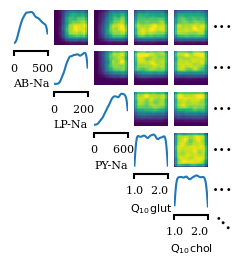

In [46]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    q10_samples = general_prior.sample((sample_params_11.shape[0],))[:, -10:]
    sample_params_11_q10 = np.concatenate((sample_params_11, q10_samples), axis=1)
    sample_params_11_norm = (sample_params_11_q10 - params_mean_41) / params_std_41
    _ = samples_nd(
        samples=sample_params_11_norm[:10020],
        subset=[0,8,16,31,32],
        upper=['kde'],
        diag=['kde'],
        fig_size=(2.5,2.5),
        limits=lims_15,
        ticks=lims_15,
        tick_labels=all_labels,
        labels=labels_,
    )
    plt.savefig(PANEL_A1, facecolor='None', transparent=True)

/home/michael/Documents/STG_energy/stg_energy/common.py:625: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:


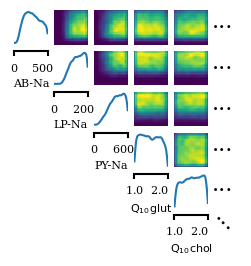

In [45]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    sample_params_27_norm = (sample_params_27 - params_mean_41) / params_std_41
    _ = samples_nd(
        samples=sample_params_27_norm[:10000],
        subset=[0,8,16,31,32],
        upper=['kde'],
        diag=['kde'],
        fig_size=(2.5,2.5),
        limits=lims_15,
        ticks=lims_15,
        tick_labels=all_labels,
        labels=labels_,
    )
    plt.savefig(PANEL_A2, facecolor='None', transparent=True)

### Temperature: 27deg. Check how many samples from 11deg, 15deg,..., 27deg posterior produce no NaN
This is rather just a sanity check

In [16]:
hyperparams_11.model_params.temp = 299

In [17]:
# sims_per_dataset = 10
# num_good_in_dataset = []
# for dataset_temp in [sample_params_11, sample_params_27]:
#     print("New dataset")
#     counter_good = 0
#     for sample_ind in range(sims_per_dataset):
#         if dataset_temp.shape[1] == 31:
#             q10 = general_prior.sample((1,)).numpy()[0, -10:]
#             parameter_set = np.concatenate((dataset_temp[sample_ind].astype(np.float64), q10),)
#         else:
#             parameter_set = dataset_temp[sample_ind].astype(np.float64)
#         out_target = simulate_general(
#             deepcopy(parameter_set),
#             hyperparams_11,
#             seed=0,
#         )
#         ss = stats(out_target)
#         if np.invert(np.any(np.isnan(ss[:15]))):
#             counter_good += 1
#     num_good_in_dataset.append(counter_good)
# print("Percentage of good samples for 11 and 27 degree posteriors:", np.asarray(num_good_in_dataset)/sims_per_dataset*100)

# Plot a sample from the 27deg posterior across temperatures

/home/michael/anaconda3/envs/sbi_prinz/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


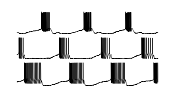

/home/michael/anaconda3/envs/sbi_prinz/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<Figure size 640x480 with 0 Axes>

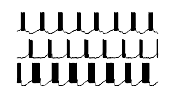

<Figure size 640x480 with 0 Axes>

In [48]:
sample_index = 2
parameter_set = sample_params_27[sample_index].astype(np.float64)

for temp in [283, 299]:

    hyperparams_11.model_params.temp = temp

    out_target = simulate_general(
        deepcopy(parameter_set),
        hyperparams_11,
        seed=0,
    )

    with mpl.rc_context(fname="../../.matplotlibrc"):
        fig, ax = plt.subplots(1, 1, facecolor="white", figsize=(2.0, 1.0))
        fig = vis_sample_plain(
            out_target,
            get_time(),
            ax,
            time_len=150000,
            col='k',
            scale_bar=False,
        )
        plt.show()
        if temp == 283:
            plt.savefig(PANEL_B1, facecolor='None', transparent=True)
        elif temp == 299:
            plt.savefig(PANEL_B2, facecolor='None', transparent=True)

# Relation between energy efficiency and temperature robustness

### Load samples from 27deg posterior. Samples have been rejected if too far from obs at 11deg and then been simulated at 27deg

In [19]:
all_energies_per_spike_11 = sample_stats_11[:, 18:21]
num_spikes_11 = sample_stats_11[:, 24:27]
all_total_energies_11 = sample_stats_11[:, 21:24]

all_energies_per_spike_27 = sample_stats_27[:, 19:22]
num_spikes_27 = sample_stats_27[:, 31:34]
all_total_energies_27 = sample_stats_27[:, 28:31]

In [20]:
summed_energies_per_spike_11 = np.asarray(all_energies_per_spike_11)[:, 0] # look at AB/PD
summed_energies_total_11 = np.sum(np.asarray(all_total_energies_11), axis=1)

summed_energies_per_spike_27 = np.asarray(all_energies_per_spike_27)[:, 0] # look at AB/PD
summed_energies_total_27 = np.sum(np.asarray(all_total_energies_27), axis=1)

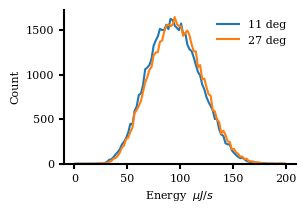

In [21]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(3,2))

    hist_vals_11 = ax.hist(summed_energies_total_11/40000, range=(0, 200), bins=100, color='w')
    hist_vals_27 = ax.hist(summed_energies_total_27/40000, range=(0, 200), bins=100, color='w')

    hist_diff = hist_vals_11[1][1] - hist_vals_11[1][0]
    line11 = ax.plot(hist_vals_11[1][:-1]+hist_diff/2, hist_vals_11[0])
    line27 = ax.plot(hist_vals_27[1][:-1]+hist_diff/2, hist_vals_27[0])
    ax.set_ylabel('Count')
    ax.set_xlabel('Energy  $\mu J/s$')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.legend((line11[0], line27[0]), ('11 deg', '27 deg'))

    plt.savefig(PANEL_C1, facecolor='None', transparent=True)

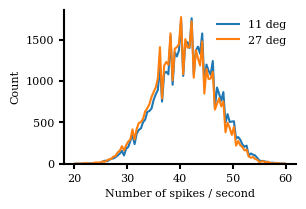

In [22]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(3,2))

    hist_vals_11 = ax.hist(np.sum(num_spikes_11, axis=1)/10, range=(20, 60), bins=100, color='w')
    hist_vals_27 = ax.hist(np.sum(num_spikes_27, axis=1)/10, range=(20, 60), bins=100, color='w')

    hist_diff = hist_vals_11[1][1] - hist_vals_11[1][0]
    line11 = ax.plot(hist_vals_11[1][:-1]+hist_diff/2, hist_vals_11[0])
    line27 = ax.plot(hist_vals_27[1][:-1]+hist_diff/2, hist_vals_27[0])
    ax.set_ylabel('Count')
    ax.set_xlabel('Number of spikes / second')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.legend((line11[0], line27[0]), ('11 deg', '27 deg'))

    plt.savefig(PANEL_C1, facecolor='None', transparent=True)

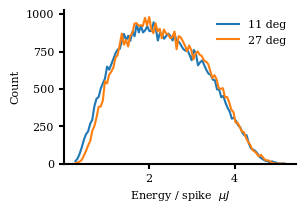

In [23]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(3,2))
    hist_vals_11 = ax.hist(summed_energies_per_spike_11/4000, bins=100, color='w')
    hist_vals_27 = ax.hist(summed_energies_per_spike_27/4000, bins=100, color='w')

    hist_diff = hist_vals_11[1][1] - hist_vals_11[1][0]
    ax.plot(hist_vals_11[1][:-1]+hist_diff/2, hist_vals_11[0])
    ax.plot(hist_vals_27[1][:-1]+hist_diff/2, hist_vals_27[0])
    ax.set_ylabel('Count')
    ax.set_xlabel('Energy / spike  $\mu J$')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.legend((line11[0], line27[0]), ('11 deg', '27 deg'))

    plt.savefig(PANEL_C2, facecolor='None', transparent=True)

### Analyse reasons for small shift in histogramms

# Compose figure

In [41]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [42]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "11.4cm",
    
    Panel(
          SVG(PANEL_A1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("a", 0.0*factor_svg, 2.6*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 0*factor_svg),
    
    Panel(
          SVG(PANEL_A2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(30*factor_svg, 0*factor_svg),
    
    Panel(
          SVG(PANEL_B1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("b", 0.0*factor_svg, 2.6*factor_svg, **kwargs_text),
    ).move(60*factor_svg, 0*factor_svg),
    
    Panel(
          SVG(PANEL_B2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(90*factor_svg, 0*factor_svg),
    
    Panel(
          SVG(PANEL_C1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", 0.0*factor_svg, 2.6*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 30*factor_svg),
           
    Panel(
          SVG(PANEL_C2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(30*factor_svg, 30*factor_svg)
    
)

!mkdir -p fig
f.save("../fig/fig7.svg")
svg('../fig/fig7.svg')